In [150]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import defaultdict, deque
import time
import os
import json
from itertools import permutations

In [151]:
tasks = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('D', 'E')]
delays = {'A': 1, 'B': 1, 'C': 4, 'D': 1, 'E': 3}

In [152]:
class Individual:
    def __init__(self, schedule, edges, delay):
        self.schedule = schedule
        self.fitness = self.calc_fitness(edges, delay)

    #ako ne zadovoljava topsort fitness->inf inace izracunaj max(S)
    def calc_fitness(self, edges, delay):
        if not is_valid_schedule(self.schedule, edges):
            return float('-inf')
        graph, predak = inicialize_graph(edges)
        return -calculate_S(self.schedule, graph, delay, predak)[1]
        
    def __lt__(self, other):
        return self.fitness < other.fitness

In [153]:
def is_valid_schedule(schedule, edges):
    """Check if the schedule respects the precedence constraints."""
    task_to_index = {task: index for index, task in enumerate(schedule)}
    for u, v in edges:
        if task_to_index[u] > task_to_index[v]:
            return False
    return True

In [154]:
def inicialize_graph(edges):
    graph = defaultdict(list)
    predak = defaultdict(list)

    for u, v in edges:
        graph[u].append(v)
        predak[v].append(u)

    return graph, predak

In [155]:
def calculate_S(permutation, graph, delay, predak):
    S = {t: 0 for t in permutation}
    for node in permutation:
        max_S = S[node]
        for prec in predak[node]:
            max_S = max(S[node], S[prec] + delay[prec] + 1)

        #ako postoji node sa istim S, uvecamo ga za 1
        while max_S in S.values():
            max_S += 1
        S[node] = max_S

    return S, max(S.values())

In [156]:
def schedule_permutations(schedule):
    for perm in permutations(schedule):
        yield perm

In [157]:
next(permutations(tasks))

('A', 'B', 'C', 'D', 'E')

In [158]:
def create_initial_population(size_of_population):
    population = [] 
    all_permutations = list(permutations(tasks))

    if size_of_population > len(all_permutations):
        raise ValueError("The size of the population exceeds the number of unique permutations.")

    random.shuffle(all_permutations)
    selected_permutations = all_permutations[:size_of_population]
    
    for schedule in selected_permutations:
        individual = Individual(schedule, edges, delays)
        population.append(individual)
        
    return population

In [159]:
def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    return max(chosen)

In [174]:
def crossover(parent1, parent2):
    """Perform crossover between two parents to create a child."""
    idx1, idx2 = sorted(random.sample(range(len(tasks)), 2))
    child = [None] * len(tasks)
    child[idx1:idx2+1] = parent1.schedule[idx1:idx2+1]
    
    current_pos = 0
    for task in parent2.schedule:
        if task not in child:
            while child[current_pos] is not None:
                current_pos += 1
            child[current_pos] = task
    return child

In [182]:
def mutate(individual):
    """Perform mutation by swapping two random tasks."""
    idx1, idx2 = random.sample(range(len(tasks)), 2)
    individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

In [188]:
def genetic_algorithm(population_size, num_generations, tournament_size, elitism_size, mutation_prob):
    population = create_initial_population(population_size)
    new_population = []
    start_time = time.time()
    
    for i in range(num_generations):
        population = sorted(population, reverse=True)
        new_population[:elitism_size] = population[:elitism_size]
        for j in range(elitism_size, population_size):
            parent1 = selection(population, tournament_size)#nz dal se razlikuju
            parent2 = selection(population, tournament_size)

            child_schedule = crossover(parent1, parent2)
            
            if random.random() < mutation_prob:
                mutate(child_schedule)
                
            new_population.append(Individual(child_schedule, edges, delays))
            
        population = new_population.copy()
        
    end_time = time.time()
    time_taken = end_time - start_time
    best_individual = max(population)
    print(f'solution: {best_individual.schedule}, cost: {-best_individual.fitness}, time taken: {time_taken}')

In [189]:
# Run the genetic algorithm
genetic_algorithm(  population_size=100, 
                    num_generations=50, 
                    tournament_size=7,
                    elitism_size=3,
                    mutation_prob=0.1)


solution: ('H', 'F', 'D', 'G', 'E', 'C', 'I', 'B', 'A'), cost: inf, time taken: 0.07392454147338867


In [190]:
def draw_graph(tasks, edges, delays):
    G = nx.DiGraph()
    
    G.add_nodes_from(tasks)
    
    # Add edges with weights (delays)
    G.add_edges_from(edges)
    
    # Define positions for nodes using a layout
    pos = nx.spring_layout(G)
    
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=3000, font_size=16, font_color='black', arrowstyle='-|>', arrowsize=20)
    
    # Draw the delays as separate text next to the nodes
    for node, (x, y) in pos.items():
        plt.text(x + 0.09, y - 0.075, s=f"Delay: {delays[node]}", bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center', fontsize=12, color='blue')
    
    # Show the plot
    plt.show()

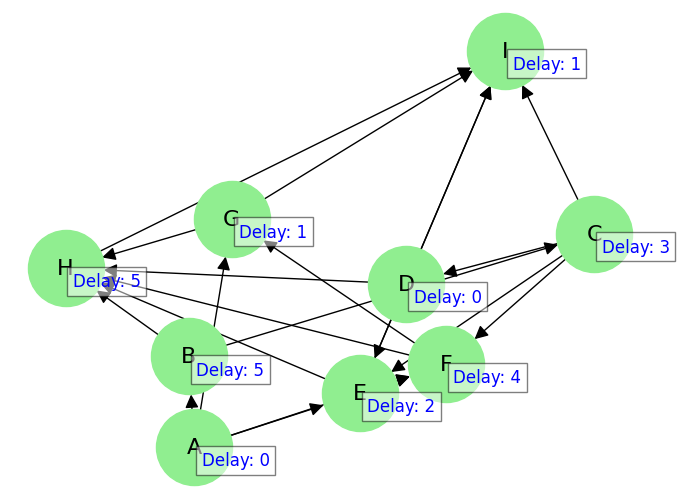

In [191]:
draw_graph(tasks, edges, delays)

In [59]:
def save_results(file, data):
    with open(file, 'w') as file:
        json.dump(data, file, indent=4)
    print(f"Data saved to {file}")

solution: ('A', 'B', 'C', 'D', 'E'), cost: 6, time taken: 0.13217592239379883


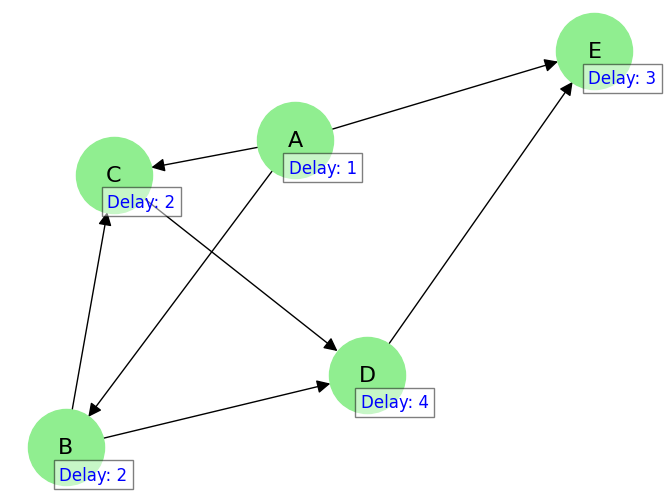

----------------------------------------------
solution: ['A', 'B', 'C', 'D', 'E', 'F'], cost: 13, time taken: 0.17658543586730957


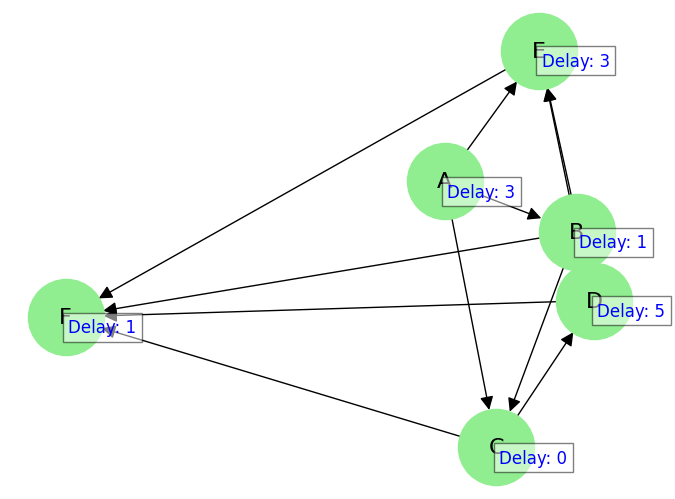

----------------------------------------------
solution: ['A', 'B', 'C', 'D', 'E', 'F', 'G'], cost: 19, time taken: 0.0747983455657959


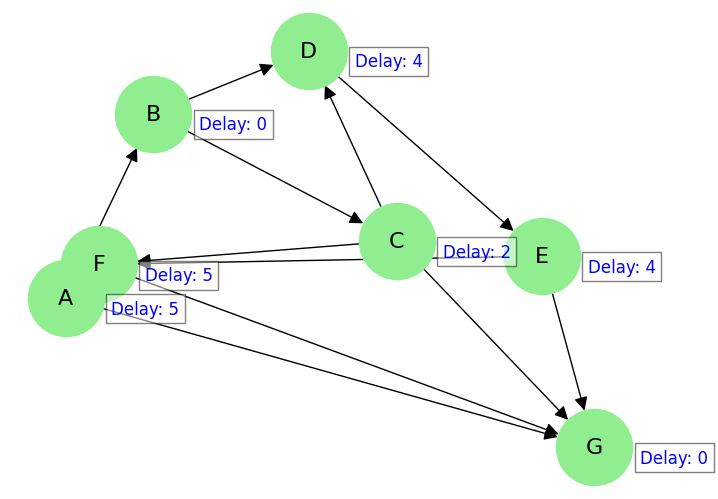

----------------------------------------------
solution: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], cost: 16, time taken: 0.07579684257507324


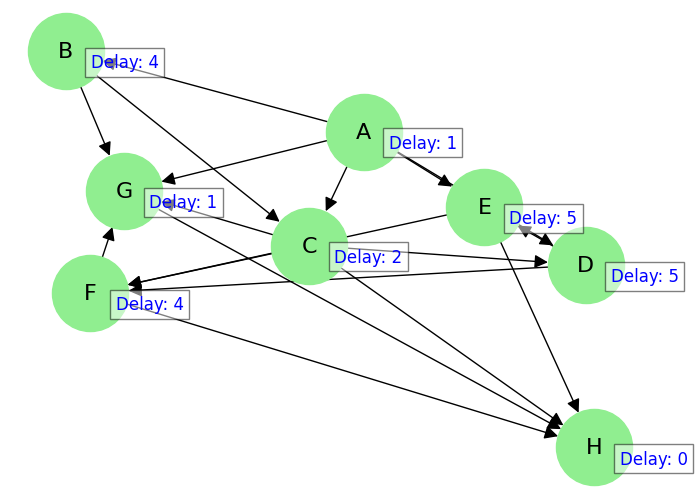

----------------------------------------------
solution: ('E', 'A', 'F', 'D', 'H', 'B', 'G', 'C', 'I'), cost: inf, time taken: 0.07682228088378906


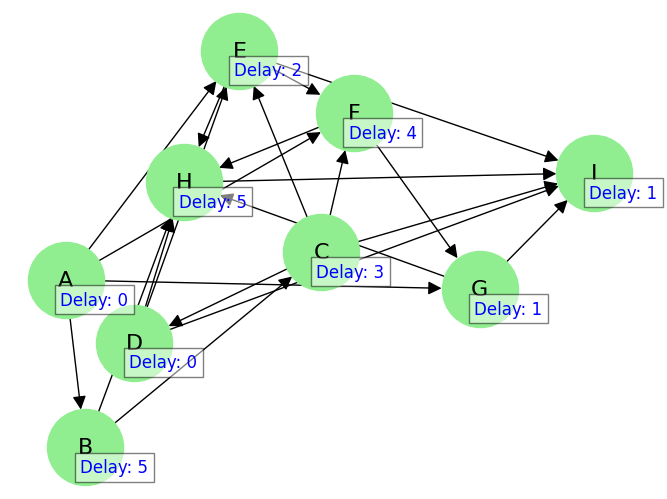

----------------------------------------------


In [192]:
path = 'test_files/'
files = os.listdir(path)
# Filter files that match the pattern 'test_file_*.py'
data_files = [f for f in files if f.startswith('test_file_') and f.endswith('.json')]
data_to_write = []
# Loop through each file and import the data
for file_name in data_files:
    file_path = os.path.join(path, file_name)
    with open(file_path, 'r') as f:
        loaded_data = json.load(f)
        tasks = loaded_data.get('tasks')
        edges = loaded_data.get('edges')
        delays = loaded_data.get('delays')

        # finish_times, finish_time, order_of_tasks, time_taken = mpcs(tasks, edges, delays)
        genetic_algorithm(population_size=100, 
                                                    num_generations=50, 
                                                    tournament_size=7,
                                                    elitism_size=3,
                                                    mutation_prob=0.1)
        # print("The order of the task completion:", best_schedule)
        # print("Earliest completion times for each task:", finish_times)
        # print("Minimum finish time:", best_finish_time)
        # print("Time taken to find a solution:", time_taken)
        draw_graph(tasks, edges, delays)
        print("----------------------------------------------")
#         data = {
#         'test_name' : file_name,
#         'order_of_tasks': best_schedule,
#         'finish_times': finish_times,
#         'finish_time': best_finish_time,
#         'time_taken': time_taken
#         }
#         data_to_write.append(data)

# result_file = 'results/GA.json'
# save_results(result_file, data_to_write)

In [20]:
# import random

# edges = []
# for i in range(1, 30001):
#     # Define the range of nodes that can be connected to
#     start = i + 1
#     end = min(i + 5, 30001)  # Ensure we do not go out of bounds
#     # Compute the maximum number of targets we can sample
#     max_targets = end - start
#     if max_targets > 0:
#         num_connections = random.randint(1, min(5, max_targets))  # Random number of connections within the bounds
#         targets = random.sample(range(start, end), num_connections)
#         for target in targets:
#             edges.append((f'T{i}', f'T{target}'))

In [21]:
# import random

# delays = {f'T{i}': random.randint(1, 10) for i in range(1, 30001)}